<a href="https://colab.research.google.com/github/ZyLiao-0011/NX414/blob/Zhiyan/data_driven.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.nn import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

from tqdm import tqdm
import numpy as np
import pandas as pd
import h5py
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/nx414')
from utils import load_it_data, visualize_img

In [5]:
path_to_data = '/content/drive/MyDrive/nx414' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [6]:
class SpikeData(Dataset):
    def __init__(self,stimulus,spike = None):
        self.stimulus = torch.tensor(stimulus)

        if spike is not None:
          self.spike = torch.tensor(spike)
          self.num_neuron = self.spike.shape[1]
        else:
          self.spike = None
          self.num_neuron = None

    def __len__(self):
        return len(self.stimulus)

    def __getitem__(self, idx):
        if self.spike is not None:
            return self.stimulus[idx], self.spike[idx]
        else:
            return self.stimulus[idx]

In [7]:
ITdataloader_train = DataLoader(SpikeData(stimulus_train, spikes_train), batch_size=64, shuffle=True)
ITdataloader_val = DataLoader(SpikeData(stimulus_val, spikes_val), batch_size=64, shuffle=False)
ITdataloader_test = DataLoader(SpikeData(stimulus_test,spike = None), batch_size=64, shuffle=False)

In [7]:
class ShallowCNN(nn.Module):
    def __init__(self,num_neuron):
        super(ShallowCNN, self).__init__()

        # Conv block 1
        self.convblock1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(16),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Conv block 2
        self.convblock2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(32),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Conv block 3
        self.convblock3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Adaptive flatten to work for 224x224 input images
        self.flatten = nn.Flatten()

        # Calculate the size of the feature map after conv blocks
        # For 224x224 input -> 112 -> 56 -> 28 after 3 maxpools
        conv_output_size = 64 * (224 // 8) * (224 // 8)  # 64 channels, 28x28 feature map

        self.fc1 = nn.Linear(conv_output_size, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_neuron)  # Output = num_neuron = 168


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    @staticmethod # defines that the following function does not take self as input
    @torch.no_grad() # ensures that following function runs without tracking gradients
    # making the initialisation faster and more memory-efficient. The parameters remain trainable.
    def init_weights(module):
        # YOUR CODE HERE
        # raise NotImplementedError()

        # He initialization
        # Conv2d layers
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        # Linear layers
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            nn.init.zeros_(module.bias)

        # Initialize BatchNorm weights to 1 and bias to 0
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

In [21]:
class ShallowCNN2(nn.Module):
    def __init__(self,num_neuron):
        super(ShallowCNN2, self).__init__()

        # Conv block 1
        self.convblock1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(16),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Conv block 2
        self.convblock2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(32),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Conv block 3
        self.convblock3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        self.convblock4 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Adaptive flatten to work for 224x224 input images
        self.flatten = nn.Flatten()

        # Calculate the size of the feature map after conv blocks
        # For 224x224 input -> 112 -> 56 -> 28 after 3 maxpools
        conv_output_size = 128 * (224 // 16) * (224 // 16)  # 64 channels, 28x28 feature map

        self.fc1 = nn.Linear(conv_output_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_neuron)  # Output = num_neuron = 168


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    @staticmethod # defines that the following function does not take self as input
    @torch.no_grad() # ensures that following function runs without tracking gradients
    # making the initialisation faster and more memory-efficient. The parameters remain trainable.
    def init_weights(module):
        # YOUR CODE HERE
        # raise NotImplementedError()

        # He initialization
        # Conv2d layers
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        # Linear layers
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            nn.init.zeros_(module.bias)

        # Initialize BatchNorm weights to 1 and bias to 0
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

In [17]:
class MobilnetStudent(nn.Module):
    def __init__(self, num_neuron):
        super(MobilnetStudent, self).__init__()
        self.model = nn.Sequential(
            # Initial Convolutional Block 1
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU6(inplace=True),

            # Convolutional Block 2
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),

            # Convolutional Block 3
            nn.Conv2d(32, 64, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(64),

            # First Inverted Residual Block
            nn.Conv2d(64, 128, kernel_size=1, bias=False),  # Expansion
            nn.BatchNorm2d(128),
            nn.ReLU6(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, groups=128, bias=False),  # Depthwise Conv
            nn.BatchNorm2d(128),
            nn.ReLU6(inplace=True),
            nn.Conv2d(128, 64, kernel_size=1, bias=False),  # Projection
            nn.BatchNorm2d(64),

            # Convolutional Block 4 (downsampling to 16x16)
            nn.Conv2d(64, 128, kernel_size=2, stride=2, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU6(inplace=True),

            # Convolutional Block 5
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU6(inplace=True),

            # Convolutional Block 6
            nn.Conv2d(256, 256, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(256),

            # Second Inverted Residual Block
            nn.Conv2d(256, 512, kernel_size=1, bias=False),  # Expansion
            nn.BatchNorm2d(512),
            nn.ReLU6(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, groups=512, bias=False),  # Depthwise Conv
            nn.BatchNorm2d(512),
            nn.ReLU6(inplace=True),
            nn.Conv2d(512, 128, kernel_size=1, bias=False),  # Projection
            nn.BatchNorm2d(128),


            # Final Expansion and Projection Layer
            nn.Conv2d(128, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU6(inplace=True),

            nn.AdaptiveAvgPool2d((2, 2)),
            nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, num_neuron)
        )


    def forward(self, x):
        out = self.model(x)
        return out

    @staticmethod # defines that the following function does not take self as input
    @torch.no_grad() # ensures that following function runs without tracking gradients
    # making the initialisation faster and more memory-efficient. The parameters remain trainable.
    def init_weights(module):
        # YOUR CODE HERE
        # raise NotImplementedError()

        # He initialization
        # Conv2d layers
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        # Linear layers
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            nn.init.zeros_(module.bias)

        # Initialize BatchNorm weights to 1 and bias to 0
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

In [12]:
import copy

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=2, scheduler=None):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for stimulus, spikes in train_loader:
                stimulus, spikes = stimulus.to(device), spikes.to(device)
                optimizer.zero_grad()

                outputs = model(stimulus)
                loss = criterion(outputs, spikes)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                pbar.set_postfix(loss=running_loss / (pbar.n + 1))
                pbar.update(1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for stimulus, labels in val_loader:
                stimulus, labels = stimulus.to(device), labels.to(device)
                outputs = model(stimulus)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        if scheduler:
            scheduler.step(val_loss)

    model.load_state_dict(best_model_wts)
    return model

In [18]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
loss_fn = nn.MSELoss()
#model = ShallowCNN2(num_neuron=168)
#model.apply(ShallowCNN2.init_weights)
model = MobilnetStudent(num_neuron=168)
model.apply(MobilnetStudent.init_weights)
model.to(device)

optimizer = AdamW(model.parameters(), lr=0.005, weight_decay=1e-5)
#scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.1, patience=5)
train_model(model, ITdataloader_train, ITdataloader_val, loss_fn, optimizer, num_epochs=200, scheduler=None)

save_path = '/content/drive/MyDrive/nx414/MobilnetStudent.pth'
torch.save(model.state_dict(), save_path)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 1.38 MiB is free. Process 25305 has 22.15 GiB memory in use. Of the allocated memory 21.92 GiB is allocated by PyTorch, and 18.69 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [29]:
load_path = '/content/drive/MyDrive/nx414/shallow_cnn2.pth'
model = ShallowCNN2(num_neuron=168)
model.to(device)
model.load_state_dict(torch.load(load_path))

<All keys matched successfully>

In [30]:
model.eval()

prediction_train = []

ITdataloader_train2 = DataLoader(SpikeData(stimulus_train, spikes_train), batch_size=64, shuffle=False)

with torch.no_grad():
    for stimulus, _ in ITdataloader_train2:
        inputs = stimulus.to(device)
        outputs = model(inputs)
        prediction_train.append(outputs.cpu())

prediction_train = torch.cat(prediction_train, dim=0)
prediction_train.shape

torch.Size([2592, 168])

In [31]:
model.eval()

prediction_val = []

with torch.no_grad():
    for stimulus, _ in ITdataloader_val:
        inputs = stimulus.to(device)
        outputs = model(inputs)
        prediction_val.append(outputs.cpu())

prediction_val = torch.cat(prediction_val, dim=0)
prediction_val.shape

torch.Size([288, 168])

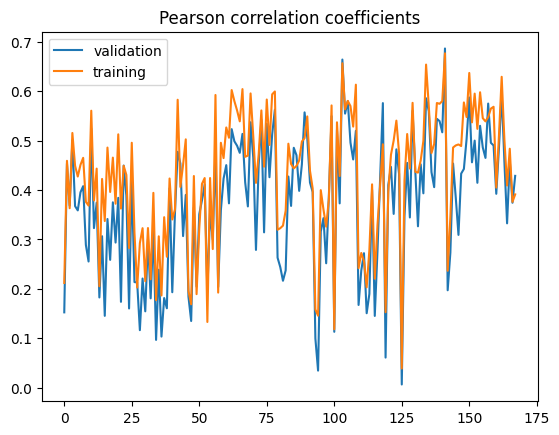

Pearson correlation on training set: 0.42987028299511526
Pearson correlation on validation set: 0.37296614049739985


<Figure size 640x480 with 0 Axes>

In [32]:
import matplotlib.pyplot as plt

n_neurons = spikes_train.shape[1]

pearson_corr_shallowcnn = np.zeros((n_neurons,2))
for i in range(n_neurons):
    pearson_corr_shallowcnn[i,0] = np.corrcoef(spikes_train[:, i],prediction_train[:, i])[0, 1]
    pearson_corr_shallowcnn[i,1] = np.corrcoef(spikes_val[:, i],prediction_val[:, i])[0, 1]
plt.figure()
plt.title('Pearson correlation coefficients')
plt.plot(pearson_corr_shallowcnn[:,1], label='validation')
plt.plot(pearson_corr_shallowcnn[:,0], label='training')
plt.legend()
plt.show()
plt.figure()

print(f"Pearson correlation on training set: {np.mean(pearson_corr_shallowcnn[:,0])}")
print(f"Pearson correlation on validation set: {np.mean(pearson_corr_shallowcnn[:,1])}")

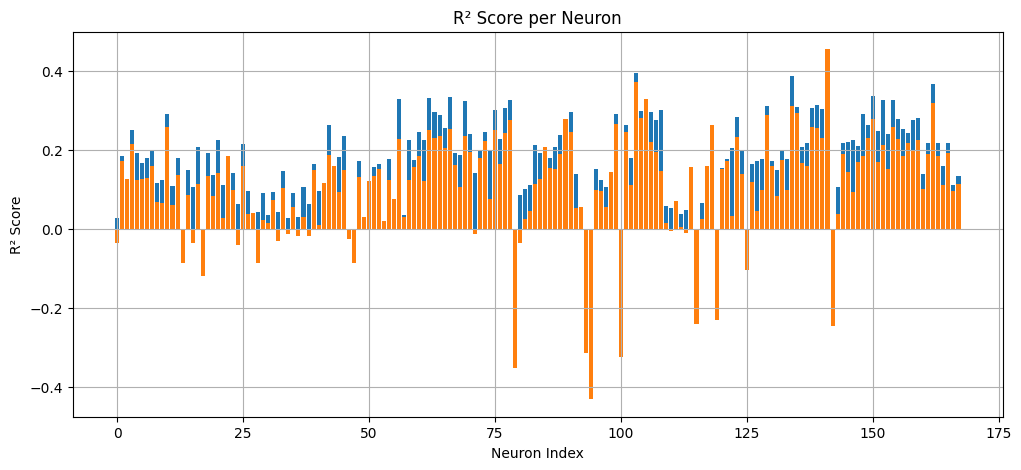

In [26]:
from sklearn.metrics import r2_score

r2_train = [r2_score(spikes_train[:, i], prediction_train[:, i]) for i in range(spikes_train.shape[1])]
r2_val = [r2_score(spikes_val[:, i], prediction_val[:, i]) for i in range(spikes_val.shape[1])]

plt.figure(figsize=(12, 5))
plt.bar(range(len(r2_train)), r2_train)
plt.bar(range(len(r2_val)), r2_val)
plt.xlabel('Neuron Index')
plt.ylabel('R² Score')
plt.title('R² Score per Neuron')
plt.grid(True)
plt.show()

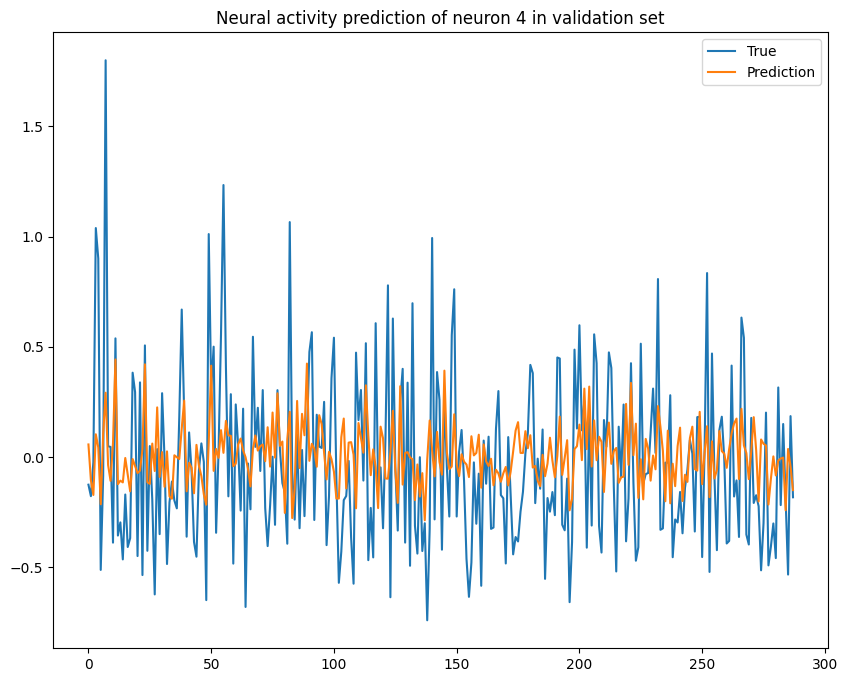

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [27]:
example_id = 4

plt.figure(figsize= (10,8))
plt.title(f'Neural activity prediction of neuron {example_id} in validation set')
plt.plot(spikes_val[:,example_id], label = "True")
plt.plot(prediction_val[:,example_id], label = "Prediction")
plt.legend()
plt.show()
plt.figure()

In [18]:
ITdataloader_test.dataset.stimulus

tensor([[[[0.0741, 0.0741, 0.0741,  ..., 0.0741, 0.0741, 0.0741],
          [0.0741, 0.0741, 0.0741,  ..., 0.0741, 0.0741, 0.0741],
          [0.0741, 0.0741, 0.0741,  ..., 0.0741, 0.0741, 0.0741],
          ...,
          [0.0741, 0.0741, 0.0741,  ..., 0.0741, 0.0741, 0.0741],
          [0.0741, 0.0741, 0.0741,  ..., 0.0741, 0.0741, 0.0741],
          [0.0741, 0.0741, 0.0741,  ..., 0.0741, 0.0741, 0.0741]],

         [[0.2052, 0.2052, 0.2052,  ..., 0.2052, 0.2052, 0.2052],
          [0.2052, 0.2052, 0.2052,  ..., 0.2052, 0.2052, 0.2052],
          [0.2052, 0.2052, 0.2052,  ..., 0.2052, 0.2052, 0.2052],
          ...,
          [0.2052, 0.2052, 0.2052,  ..., 0.2052, 0.2052, 0.2052],
          [0.2052, 0.2052, 0.2052,  ..., 0.2052, 0.2052, 0.2052],
          [0.2052, 0.2052, 0.2052,  ..., 0.2052, 0.2052, 0.2052]],

         [[0.4265, 0.4265, 0.4265,  ..., 0.4265, 0.4265, 0.4265],
          [0.4265, 0.4265, 0.4265,  ..., 0.4265, 0.4265, 0.4265],
          [0.4265, 0.4265, 0.4265,  ..., 0

In [23]:
model.eval()

prediction_test = []

with torch.no_grad():
    for stimulus in ITdataloader_test:
        inputs = stimulus.to(device)
        outputs = model(inputs)
        prediction_test.append(outputs.cpu())

prediction_test = torch.cat(prediction_test, dim=0)
prediction_test.shape

torch.Size([320, 168])

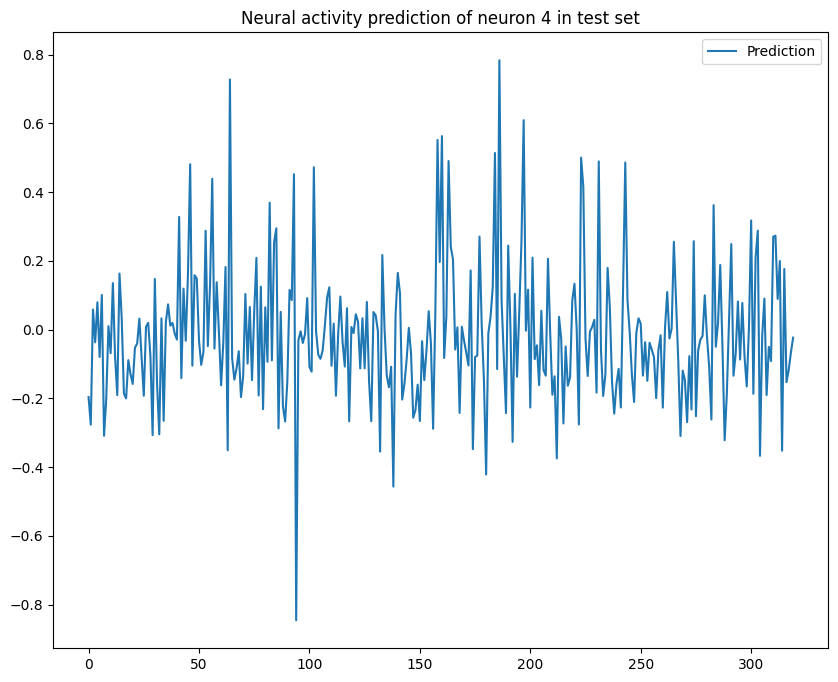

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [24]:
example_id = 4

plt.figure(figsize= (10,8))
plt.title(f'Neural activity prediction of neuron {example_id} in test set')
plt.plot(prediction_test[:,example_id], label = "Prediction")
plt.legend()
plt.show()
plt.figure()